## Stock price prediction and forecast ARIMA.

In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import statistics 
import re
from collections import defaultdict

In [3]:
df=pd.read_csv("NVDAcsvv.csv", decimal = ',')
df.head()

,Date,Open,Close,High,Low,Volume
0,4-Jan-16,32.290001,32.369999,32.580002,32.040001,8951900
1,5-Jan-16,32.98,32.889999,33.439999,32.5,12256800
2,6-Jan-16,32.349998,31.530001,32.5,31.16,11233600
3,7-Jan-16,30.74,30.280001,30.950001,29.879999,16132600
4,8-Jan-16,30.67,29.629999,30.700001,29.57,9961800


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 6 columns):
Date      878 non-null object
Open      878 non-null object
Close     878 non-null object
High      878 non-null object
Low       878 non-null object
Volume    878 non-null int64
dtypes: int64(1), object(5)
memory usage: 41.2+ KB


In [5]:
df['Open']=df['Open'].astype(float)
df['Close']=df['Close'].astype(float)
df['High']=df['High'].astype(float)
df['Low']=df['Low'].astype(float)

In [6]:
df.describe()

,Open,Close,High,Low,Volume
count,878.000000,878.000000,878.000000,878.000000,8.780000e+02
mean,147.423964,147.361560,149.602779,144.971617,1.396805e+07
std,74.841028,74.703322,75.826815,73.624875,8.135341e+06
min,24.780001,25.219999,25.559999,24.750000,4.382600e+06
25%,84.780001,86.552501,88.335001,83.697502,8.942675e+06
50%,152.584999,151.809998,155.205002,148.904999,1.178865e+07
75%,211.750004,211.002499,214.074997,206.359997,1.635880e+07
max,289.320007,289.359985,292.760010,285.579987,9.232320e+07


In [7]:
df['Date']= pd.to_datetime(df['Date']) 
#df['year'] = pd.DatetimeIndex(df['Date']).year
df.head()

,Date,Open,Close,High,Low,Volume
0,2016-01-04,32.290001,32.369999,32.580002,32.040001,8951900
1,2016-01-05,32.980000,32.889999,33.439999,32.500000,12256800
2,2016-01-06,32.349998,31.530001,32.500000,31.160000,11233600
3,2016-01-07,30.740000,30.280001,30.950001,29.879999,16132600
4,2016-01-08,30.670000,29.629999,30.700001,29.570000,9961800


In [8]:
df.sort_values(by=['Date'], inplace = True)
df.set_index('Date', inplace= True) #set index as date and sorted the values

In [9]:
#we have opening and closing prices from 2016-2019
df.head()  

,Open,Close,High,Low,Volume
Date,,,,,
2016-01-04,32.290001,32.369999,32.580002,32.040001,8951900
2016-01-05,32.980000,32.889999,33.439999,32.500000,12256800
2016-01-06,32.349998,31.530001,32.500000,31.160000,11233600
2016-01-07,30.740000,30.280001,30.950001,29.879999,16132600
2016-01-08,30.670000,29.629999,30.700001,29.570000,9961800


In [82]:
df['close_price_change']=df['Close'].pct_change()*100
df=df.dropna(axis=0)

In [83]:
df.head()

,Date,Open,Close,High,Low,Volume,close_price_change
1,2016-01-05,32.980000,32.889999,33.439999,32.500000,12256800,1.606426
2,2016-01-06,32.349998,31.530001,32.500000,31.160000,11233600,-4.134989
3,2016-01-07,30.740000,30.280001,30.950001,29.879999,16132600,-3.964478
4,2016-01-08,30.670000,29.629999,30.700001,29.570000,9961800,-2.146638
5,2016-01-11,29.660000,29.680000,29.889999,29.150000,10234300,0.168751


In [84]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

Text(0.5, 1.0, 'NVIDIA plot')

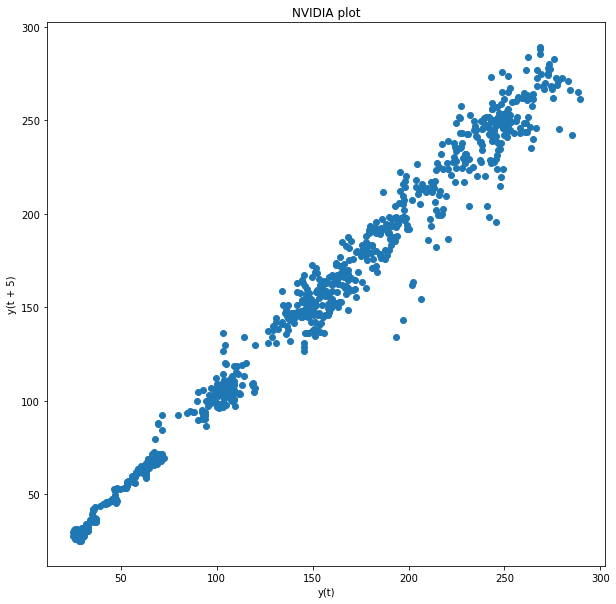

In [85]:
#analyse the autocorrelation plot of the “Open” feature (Figure 2) with 
#respect to a fixed lag of 5. The results confirmed the ARIMA would have been a good model to be applied to this type of data.

plt.figure(figsize=(10,10))
lag_plot(df['Open'], lag=5)
plt.title('NVIDIA plot')

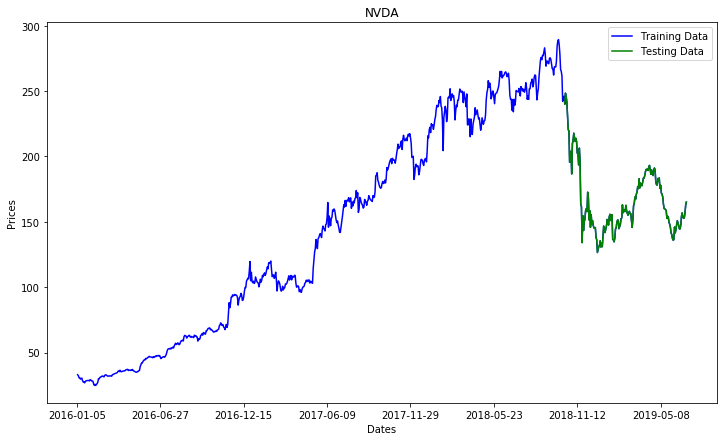

In [86]:
# In order to evaluate the ARIMA model, I decided to use two different error functions: Mean Squared Error (MSE) and Symmetric Mean Absolute Percentage Error (SMAPE). SMAPE is commonly used as an accuracy measure based on relative errors (Figure 4).
#SMAPE is not currently supported in Scikit-learn as a loss function I, therefore, had first to create this function on my own.
train_data, test_data = df[0:int(len(df)*0.8)], df[int(len(df)*0.8):]
plt.figure(figsize=(12,7))
plt.title('NVDA')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df['Open'], 'blue', label='Training Data')
plt.plot(test_data['Open'], 'green', label='Testing Data')
plt.xticks(np.arange(0,877,120),df['Date'].dt.date[0:877:120])
plt.legend()



In [87]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) +       np.abs(y_true))))

According to the MSE, the model loss is quite low but for SMAPE is instead consistently higher. One of the main reason for this discrepancy is because SMAPE is commonly used loss a loss function for Time Series problems and can, therefore, provide a more reliable analysis. That showed there is still room for improvement of our model.

In [88]:
train_ar = train_data['Open'].values
test_ar = test_data['Open'].values
history = [x for x in train_ar]
print(type(history))
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
error = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)

<class 'list'>
Testing Mean Squared Error: 45.967
Symmetric mean absolute percentage error: 16.093


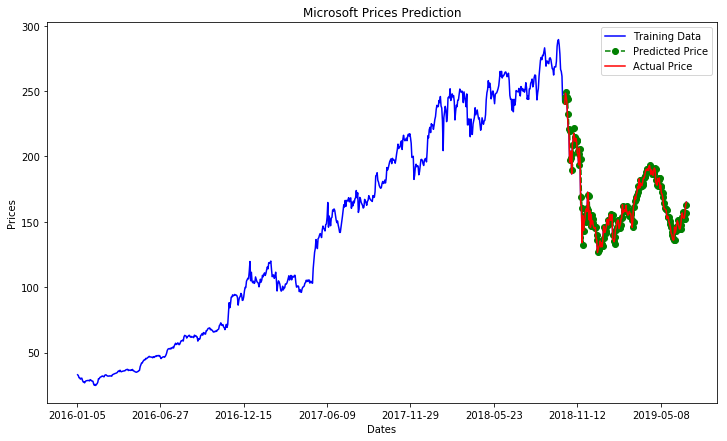

In [89]:
plt.figure(figsize=(12,7))
plt.plot(df['Open'], 'green', color='blue', label='Training Data')
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['Open'], color='red', label='Actual Price')
plt.title('Microsoft Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(np.arange(0,877,120),df['Date'].dt.date[0:877:120])
plt.legend()

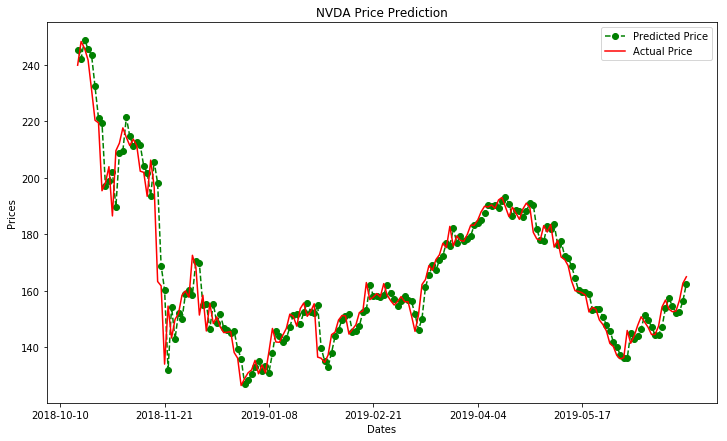

In [90]:
plt.figure(figsize=(12,7))
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_data.index, test_data['Open'], color='red', label='Actual Price')
plt.legend()
plt.title('NVDA Price Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(np.arange(697,877,30), df['Date'].dt.date[697:877:30])
plt.legend()

This analysis using ARIMA lead overall to appreciable results. This model demonstrated in fact to offer good prediction accuracy and to be relatively fast compared to other alternatives such as RRNs (Recurrent Neural Networks).